In [1]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
! pip install pyDOE

In [3]:
import importlib
importlib.import_module('mpl_toolkits').__path__

_NamespacePath(['C:\\Users\\pnguye61\\Anaconda3\\lib\\site-packages\\mpl_toolkits'])

In [4]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [5]:
import numpy as np
import torch
import torch.autograd as autograd
from torch import Tensor   
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
import scipy.io

import sympy as sm
import math


In [6]:
def plot_contour(x,t,y):
  x_plot =x
  t_plot =t
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)',size=15)
  ax.set_xlabel('t',size=15)
  ax.set_ylabel('x',size=15)
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t',size=15)
  ax.set_ylabel('x',size=15)
  ax.set_zlabel('f(x,t)',size=15)
  plt.show()

In [7]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [8]:
# define the PDE

def f_real(x,t):
    return torch.exp(-t)*(torch.sin(np.pi*x))

# Plot PDE

C:\Users\pnguye61\Anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


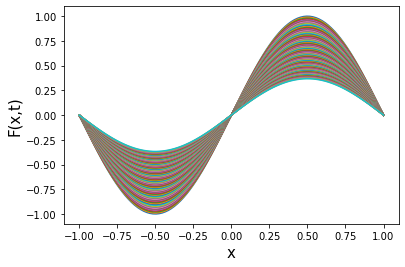

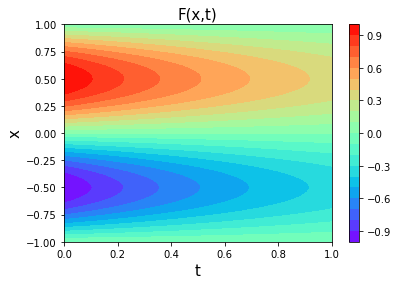

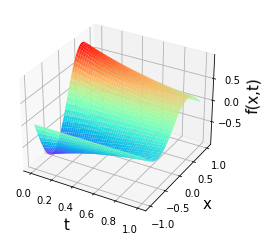

In [9]:
x= torch.linspace(-1,1,100)  # Generate data for position
t= torch.linspace(0,1,100)   # Generate data for time
X,T=torch.meshgrid(x,t)     # Create grid, so we can plot each x with different t
y_real=f_real(X,T)

# print("y_real",y_real)

# print("X",X)
# print("T",T)

plt.plot(x,y_real)
plt.xlabel("x", size=15)
plt.ylabel("F(x,t)", size=15)
plt.show()
plot_contour(x,t,y_real)

# Testing data

In [10]:
x_test = torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test = y_real.transpose(1,0).flatten()[:,None]

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_test shape: torch.Size([10000, 2])
y_test shape: torch.Size([10000, 1])


# Training data

In [11]:
from pyDOE import lhs         #Latin Hypercube Sampling

In [12]:
# Initial Condition

# y(x,0) = sin(pi*x)

# print("t0:", T[:,0])
# print("x:", X[:,0])

initial_X = torch.hstack((X[:,0][:,None],T[:,0][:,None]))

initial_Y = torch.sin(np.pi*initial_X[:,0]).unsqueeze(1)

# print("initial_x: ", initial_x)
# initial_x.shape
# print("initial_y: ", initial_y)
# initial_y.shape

# Boundary Condition

# y(-1,t) = 0 and y(1,t)=0

# Upper bound

# print("t:", T[-1,:])
# print("x:", X[-1,:])


upper_bound_X = torch.hstack((X[-1,:][:,None],T[-1,:][:,None]))
upper_bound_Y = torch.zeros(upper_bound_X.shape[0],1)

# print("upper_bound_x:", upper_bound_x)
# print("upper_bound_y:", upper_bound_y)


# Lower bound

lower_bound_X = torch.hstack((X[0,:][:,None],T[0,:][:,None]))
lower_bound_Y = torch.zeros(lower_bound_X.shape[0],1)

# print("x:", X[0,:])

X_train = torch.vstack([initial_X,upper_bound_X,lower_bound_X])
Y_train = torch.vstack([initial_Y,upper_bound_Y,lower_bound_Y])

# X_train

# Randomly choose 100 points for training

rd_points = np.random.choice(X_train.shape[0],100,replace=False)

X_train_rd = X_train[rd_points,:]
Y_train_rd = Y_train[rd_points,:]

# print("X_train_rd: ", X_train_rd)
# print("Y_train_rd: ", Y_train_rd)

# Collocation points for PDE

lb = x_test[0]
ub = x_test[-1]

#Choose(Nf) points(Latin hypercube)?

Nf = 10000
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_rd)) #Add the training poinst to the collocation points

In [13]:
print("Original shapes for X(x,t) and Y:",X.shape,y_real.shape)
print("Boundary shapes for the edges:",initial_X.shape,lower_bound_X.shape,upper_bound_X.shape)
print("Available training data:",X_train.shape,Y_train.shape)
print("Final training data:",X_train_rd.shape,Y_train_rd.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X(x,t) and Y: torch.Size([100, 100]) torch.Size([100, 100])
Boundary shapes for the edges: torch.Size([100, 2]) torch.Size([100, 2]) torch.Size([100, 2])
Available training data: torch.Size([300, 2]) torch.Size([300, 1])
Final training data: torch.Size([100, 2]) torch.Size([100, 1])
Total collocation points: torch.Size([10100, 2])


In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Store tensors to GPU

X_train_Nu=X_train_rd.float().to(device)#Training Points (BC)
Y_train_Nu=Y_train_rd.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function

X_test=x_test.float().to(device) # the input dataset (complete)
Y_test=y_test.float().to(device) # the real solution 

# Neural Network coding (available online)

In [16]:
class FCN(nn.Module):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
      f=f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))
      return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf                   
    def closure(self):
      optimizer.zero_grad()  
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()      
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss

# Create model PINN

In [17]:
layers = np.array([2,32,32,1]) # hidden layers
lr=1e-3 # learning rate
PINN = FCN(layers)
PINN.to(device)
print(PINN)

params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


# Traing PINN model

In [19]:
epochs=10

for i in range(epochs):
    
    loss = PINN.loss(X_train_rd,Y_train_rd,X_train_Nf)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
        
    with torch.no_grad():
            
        test_loss=PINN.lossBC(X_test,Y_test)

#     print("training loss:", loss,"/Testing loss: ", test_loss)

    print("training loss:", loss)


training loss: tensor(17.3741, grad_fn=<AddBackward0>)
training loss: tensor(17.2740, grad_fn=<AddBackward0>)
training loss: tensor(17.1772, grad_fn=<AddBackward0>)
training loss: tensor(17.0837, grad_fn=<AddBackward0>)
training loss: tensor(16.9932, grad_fn=<AddBackward0>)
training loss: tensor(16.9054, grad_fn=<AddBackward0>)
training loss: tensor(16.8201, grad_fn=<AddBackward0>)
training loss: tensor(16.7368, grad_fn=<AddBackward0>)
training loss: tensor(16.6554, grad_fn=<AddBackward0>)
training loss: tensor(16.5756, grad_fn=<AddBackward0>)


# Plot prediction from PINN and actual PDE

In [262]:
y_predict=PINN(X_test)

x1=X_test[:,0]
t1=X_test[:,1]


X1=x1.reshape(shape=[100,100]).transpose(1,0).detach().cpu()
T1=t1.reshape(shape=[100,100]).transpose(1,0).detach().cpu()

Y_predict=y_predict.reshape(shape=[100,100]).transpose(1,0).detach().cpu()
Y_predict

tensor([[-0.0296, -0.0304, -0.0311,  ...,  0.0587,  0.0608,  0.0629],
        [-0.0853, -0.0858, -0.0863,  ...,  0.0265,  0.0287,  0.0310],
        [-0.1412, -0.1415, -0.1417,  ..., -0.0058, -0.0034, -0.0011],
        ...,
        [ 0.1529,  0.1491,  0.1455,  ..., -0.0259, -0.0312, -0.0366],
        [ 0.0979,  0.0939,  0.0902,  ..., -0.0499, -0.0549, -0.0599],
        [ 0.0426,  0.0385,  0.0347,  ..., -0.0751, -0.0796, -0.0842]])

# Prediction by PINN

Prediction by PINN


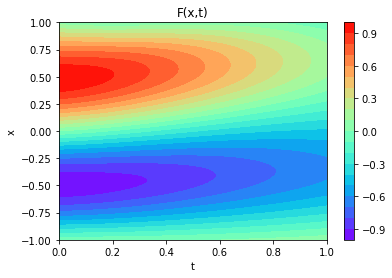

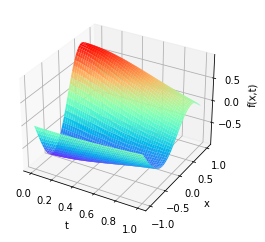

In [263]:
print("Prediction by PINN")
plot3D_Matrix(X1,T1,Y_predict)

# Actual Plot

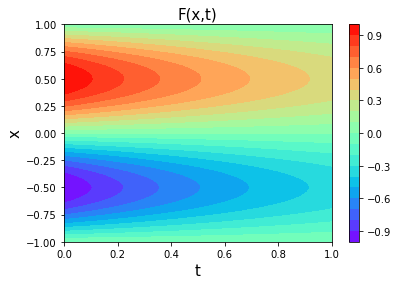

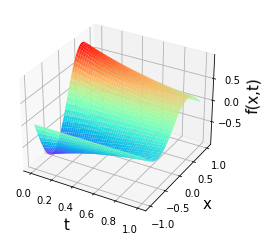

In [264]:
x= torch.linspace(-1,1,100)  # Generate data for position
t= torch.linspace(0,1,100)   # Generate data for time
X,T=torch.meshgrid(x,t)     # Create grid, so we can plot each x with different t
y_real=f_real(X,T)
plt.show()
plot_contour(x,t,y_real)